# 线性回归的基础实现
##### 数据流水线、模型、损失函数&小批量随机梯度下降优化器


In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

*先构造一个噪声数据集（线性模型）*
参数: $w=[2,-3.4]^T$ $b=4.2$


In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  #c
    return X, y.reshape((-1, 1)) #返回成列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.2742, 0.4443]) 
label: tensor([3.2493])


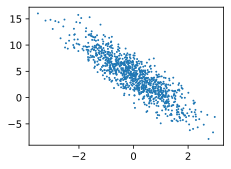

In [3]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集
定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) #随机打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.4987, -0.3382],
        [-1.6904,  0.5704],
        [-0.3643,  0.3227],
        [ 0.0333, -0.2487],
        [-0.0450,  0.1694],
        [ 2.8197, -1.6088],
        [ 1.5088, -0.9237],
        [-0.0801, -0.1935],
        [-0.0146,  0.7271],
        [ 0.4858, -0.3028]]) 
 tensor([[ 4.3404],
        [-1.1141],
        [ 2.3603],
        [ 5.1098],
        [ 3.5233],
        [15.3061],
        [10.3486],
        [ 4.6815],
        [ 1.7062],
        [ 6.2038]])


定义 初始化模型参数

In [5]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [6]:
def linreq(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) +b

定义损失函数

In [7]:
def squared_loss(y_hat ,y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

定义优化算法

In [8]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程


In [9]:
lr = 0.03
num_epochs = 3
net = linreq
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y) #X和y的小批量损失
        # 因为L的形状是(batch_size，L)，而不是一个标量。L中所有元素被加到一起，
        # 并以此计算关于【w，b】的梯度
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_1 = loss(net(features,w,b),labels)
        print(f'epoch{epoch + 1}, loss{float(train_1.mean()):f}')

epoch1, loss0.041956
epoch2, loss0.000166
epoch3, loss0.000051


In [10]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0010, -0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0001], grad_fn=<RsubBackward1>)
